<a href="https://colab.research.google.com/github/tharungajula2/Portfolio/blob/main/Project204_%E2%8F%B3ARIMA(p%2Cd%2Cq).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* An autoregressive integrated moving average process is the combination of an autoregressive
process AR(p), integration I(d), and the moving average process MA(q).
 Just like the ARMA process, the ARIMA process states that the present value is
dependent on past values, coming from the AR(p) portion, and past errors, coming
from the MA(q) portion. However, instead of using the original series, denoted as yt,
the ARIMA process uses the differenced series, denoted as y't. Note that y't can represent a series that has been differenced more than once.

* Just like in the ARMA process, the order p determines how many lagged values of the
series are included in the model, while the order q determines how many lagged error
terms are included in the model. However, in equation 7.1 you’ll notice that there is
no order d explicitly displayed.
 Here, the order d is defined as the order of integration. Integration is simply the
reverse of differencing. The order of integration is thus equal to the number of times
a series has been differenced to become stationary.

* A time series that can be rendered stationary by applying differencing is said to be an
integrated series. In the presence of a non-stationary integrated time series, we can use
the ARIMA(p,d,q) model to produce forecasts.
 Thus, in simple terms, the ARIMA model is simply an ARMA model that can be
applied on non-stationary time series. Whereas the ARMA(p,q) model requires the
series to be stationary before fitting an ARMA(p,q) model, the ARIMA(p,d,q) model
can be used on non-stationary series. We must simply find the order of integration d,
which corresponds to the minimum number of times a series must be differenced to
become stationary

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


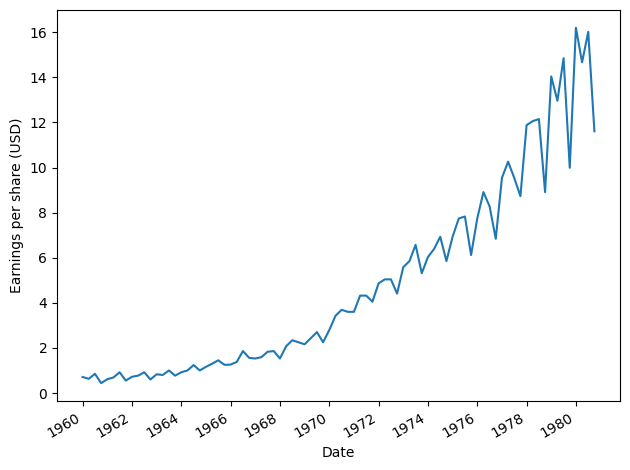

In [8]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

* shows a
positive trend, as the quarterly EPS tends to increase over time. Nevertheless, we can
apply the augmented Dickey-Fuller (ADF) test to determine if it is stationary or not

* We need to determine how many times the series must be differenced to become
stationary. This will then set the order of integration d. We can apply a first-order differencing and test for stationarity.

In [9]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574744
p-value: 1.0


In [6]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


In [7]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


* It took two rounds of differencing to make our data stationary, which means that our order of integration is 2,
so d = 2.

* To fit the many ARIMA(p,d,q) models, we’ll define the optimize_ARIMA function. It is
almost identical to the optimize_ARMA function, only this
time we’ll add the order of integration d as an input to the function. The remainder
of the function stays the same, as we fit the different models and order them by
ascending AIC in order to select the model with the lowest AIC. The optimize_ARIMA
function is shown in the following listing.

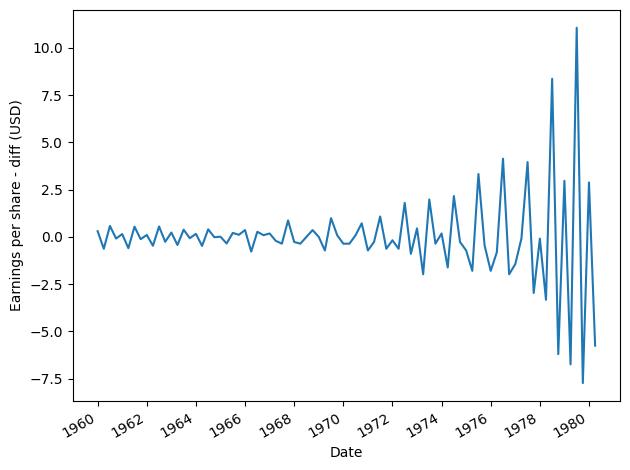

In [10]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

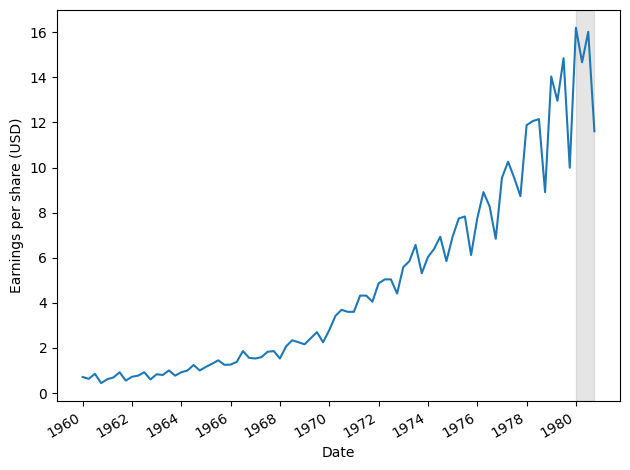

In [11]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [13]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [14]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",115.266637
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430625
4,"(0, 3)",194.654716
5,"(0, 2)",209.274868
6,"(2, 3)",220.666965
7,"(1, 3)",228.267730
8,"(1, 2)",228.935782
9,"(2, 2)",229.974691


In [15]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.633
Date:                Fri, 02 Feb 2024   AIC                            115.267
Time:                        17:02:36   BIC                            131.764
Sample:                             0   HQIC                           121.871
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9994      0.037    -26.764      0.000      -1.073      -0.926
ar.L2         -0.9882      0.040    -25.002      0.000      -1.066      -0.911
ar.L3         -0.9758      0.026    -37.598      0.0

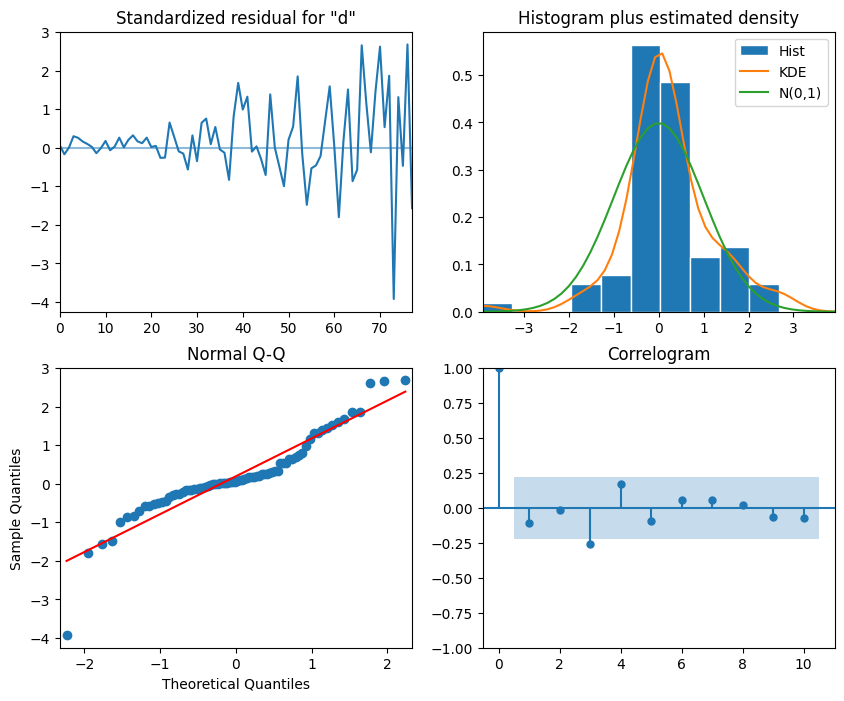

In [17]:
model_fit.plot_diagnostics(figsize=(10,8));

In [18]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [19]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [20]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.858693
81,1980-04-01,14.67,12.96,14.381508
82,1980-07-02,16.02,14.85,16.365509
83,1980-10-01,11.61,9.99,11.680906


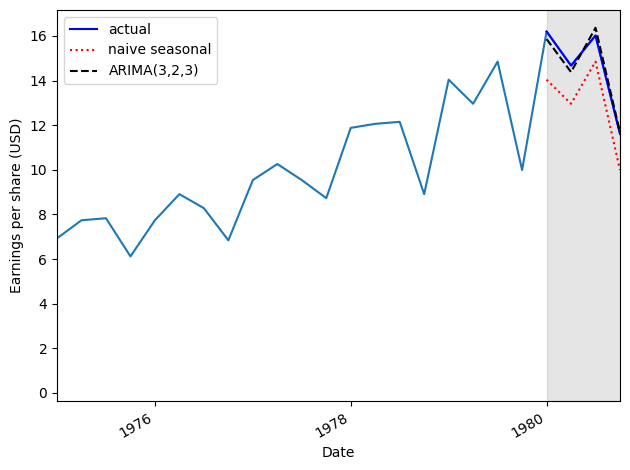

In [21]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [22]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7102112169997594


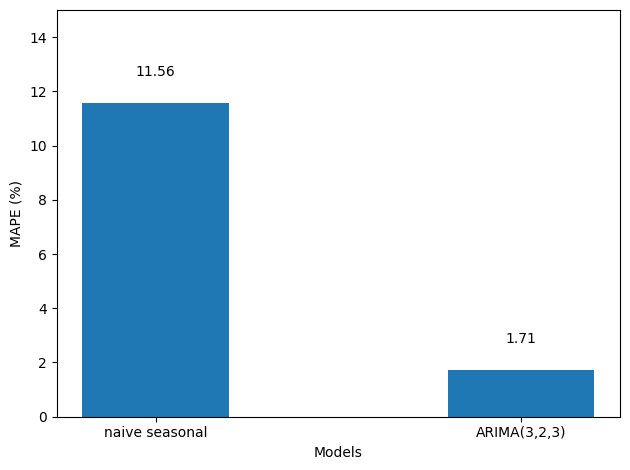

In [25]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

you can see that the MAPE for the naive seasonal forecast is 11.56%,
while the MAPE for the ARIMA(3,2,3) model is 1.71%.
This means that our predictions are on average 1.71% off from the
actual values. The ARIMA(3,2,3) model is clearly a better model than the naive seasonal method.